### Voronyi-Stepan-Camp-2025

In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN
from sklearn.svm import OneClassSVM
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [23]:
usecols = ['V10','V14','V4','V12','V11','V17','Class']
df = pd.read_csv('./data/creditcard.csv', usecols=usecols)
features = ['V10','V14','V4','V12','V11','V17']
X = df[features]
y = df['Class']
contamination = y.mean()
print(f"Доля fraud-транзакцій: {contamination:.4%}")

Доля fraud-транзакцій: 0.1727%


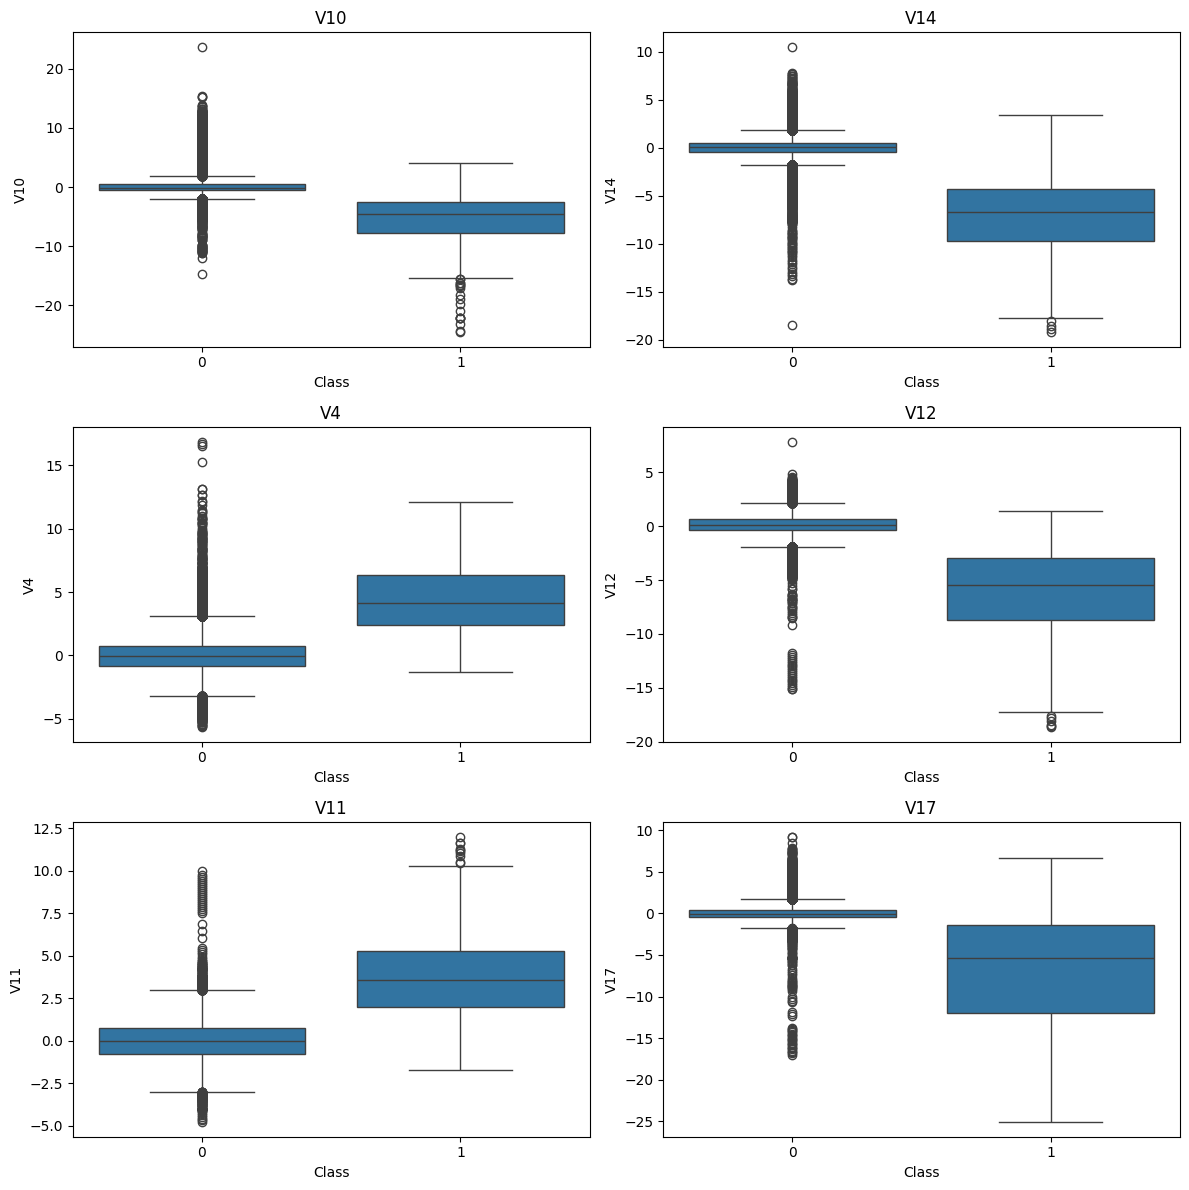

In [24]:
fig, axes = plt.subplots(3,2, figsize=(12,12))
for ax, feat in zip(axes.flatten(), features):
    sns.boxplot(x=y, y=X[feat], ax=ax)
    ax.set_title(feat)
plt.tight_layout()
plt.show()

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)

In [26]:
models = {
    'EllipticEnvelope': EllipticEnvelope(contamination=contamination, random_state=42),
    'IsolationForest': IsolationForest(contamination=contamination, random_state=42, n_jobs=-1),
    'LocalOutlierFactor': LocalOutlierFactor(n_neighbors=35, contamination=contamination),
    'DBSCAN': DBSCAN(eps=3, min_samples=5),
    'OneClassSVM': OneClassSVM(nu=contamination, kernel='rbf', gamma='scale')
}
sample_size = 5000
if len(X_test) > sample_size:
    sample_idx = X_test.sample(n=sample_size, random_state=42).index
    X_test_small = X_test.loc[sample_idx]
    y_test_small = y_test.loc[sample_idx]
else:
    X_test_small = X_test
    y_test_small = y_test

results = []
for name, model in models.items():
    if name in ['LocalOutlierFactor', 'DBSCAN', 'OneClassSVM']:
        test_data = X_test_small
    else:
        test_data = X_test

    if hasattr(model, 'fit_predict') and not isinstance(model, IsolationForest):
        raw = model.fit_predict(test_data)
    else:
        clf = clone(model)
        clf.fit(X_train)
        raw = clf.predict(test_data)
    pred = np.where(raw == 1, 0, 1)
    results.append((name, pred))

In [27]:
new_results = []
for name, model in models.items():
    if name in ['LocalOutlierFactor', 'DBSCAN', 'OneClassSVM']:
        test_data, test_labels = X_test_small, y_test_small
    else:
        test_data, test_labels = X_test, y_test

    if hasattr(model, 'fit_predict') and not isinstance(model, IsolationForest):
        raw = model.fit_predict(test_data)
    else:
        clf = clone(model)
        clf.fit(X_train)
        raw = clf.predict(test_data)

    pred = np.where(raw == 1, 0, 1)
    new_results.append((name, pred, test_labels))

summary = []
for name, pred, y_eval in new_results:
    cr = classification_report(y_eval, pred, output_dict=True, zero_division=0)
    cm = confusion_matrix(y_eval, pred)
    tp = cm[1,1]; fp = cm[0,1]; tn = cm[0,0]; fn = cm[1,0]
    summary.append({
        'Model': name,
        'Precision': cr['1']['precision'],
        'Recall': cr['1']['recall'],
        'F1': cr['1']['f1-score'],
        'TP': tp, 'FP': fp, 'TN': tn, 'FN': fn
    })

results_df = pd.DataFrame(summary).sort_values('F1', ascending=False)
results_df

,Model,Precision,Recall,F1,TP,FP,TN,FN
1,IsolationForest,0.636364,0.662162,0.649007,98,56,85239,50
0,EllipticEnvelope,0.578231,0.574324,0.576271,85,62,85233,63
2,LocalOutlierFactor,0.333333,0.600000,0.428571,3,6,4989,2
4,OneClassSVM,0.022727,0.400000,0.043011,2,86,4909,3
3,DBSCAN,0.001000,1.000000,0.001998,5,4995,0,0


Among all the tested algorithms, IsolationForest demonstrated the best performance in detecting fraudulent transactions, showing the highest F1 score with a good balance between precision and recall.To improve anomaly detection in the future i can tune model hyperparameters or experiment with different features.